Bayesian linear regression final  report

In [1]:
import pyro
import pyro.distributions as dist
import torch
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam
import numpy as np
from torch.distributions import constraints

import os
from functools import partial
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import pyro
import pyro.distributions as dist

# for CI testing
smoke_test = ('CI' in os.environ)
assert pyro.__version__.startswith('1.8.6')
pyro.set_rng_seed(1)


# Set matplotlib settings
%matplotlib inline
plt.style.use('default')

from torch import nn
from pyro.nn import PyroModule

assert issubclass(PyroModule[nn.Linear], nn.Linear)
assert issubclass(PyroModule[nn.Linear], PyroModule)

In [2]:
data = pd.read_csv("/Users/ahunos/myWork/research/Greenbaum/data_processsed/sandbox/methyl_rate_dt_rlog_DMSO_AZCT.tsv", sep="\t")
df = data[data.nCpGs_promoter_observed_data > 10]

df = df[["sample", "key", "rlog_transformed", "geom_mean_promoter_methyl"]]
df["geom_mean_promoter_methyl"] = (1- (df["geom_mean_promoter_methyl"]/100))
df.head(10)
df_all = df
#pick only one sample
# df = df[df['sample'] == 'D-A-3']

#df_all
# df.drop(columns=['sample', "key"], inplace=True)
# df.head(10)
df_sample = df_all[df_all["sample"] == 'D-0-1']
df_sample.head(10)


,sample,key,rlog_transformed,geom_mean_promoter_methyl
14312,D-0-2,1700019A02Rik_ENSMUSG00000060715.9-,1.789522,0.007334
14313,D-0-2,1700019D03Rik_ENSMUSG00000043629.12-,10.022171,0.416141
14314,D-0-2,1700025G04Rik_ENSMUSG00000032666.16-,9.757008,0.699403
14315,D-0-2,1700056E22Rik_ENSMUSG00000044854.7-,5.367508,0.832214
14316,D-0-2,1700066M21Rik_ENSMUSG00000038323.3+,10.493918,0.606066
14317,D-0-2,2310009B15Rik_ENSMUSG00000079283.2-,9.001730,0.497149
14318,D-0-2,3110009E18Rik_ENSMUSG00000026388.15+,6.854152,0.717157
14319,D-0-2,3110040M04Rik_ENSMUSG00000114582.1+,0.449300,0.215712
14320,D-0-2,4930444P10Rik_ENSMUSG00000067795.13-,0.875077,0.017135
14321,D-0-2,4933407L21Rik_ENSMUSG00000026224.11+,1.663057,0.445376


In [3]:
# Grouping by 'key' and creating a dictionary of DataFrames
grouped = df_all.groupby('key')
df_all_grouped = {name: group for name, group in grouped}
# print(grouped)
particular_key_df = df_all_grouped['1700019A02Rik_ENSMUSG00000060715.9-']
particular_key_df

,sample,key,rlog_transformed,geom_mean_promoter_methyl
0,D-0-1,1700019A02Rik_ENSMUSG00000060715.9-,1.777011,0.033609
14312,D-0-2,1700019A02Rik_ENSMUSG00000060715.9-,1.789522,0.007334
28562,D-0-3,1700019A02Rik_ENSMUSG00000060715.9-,1.786646,0.025209
42871,D-A-1,1700019A02Rik_ENSMUSG00000060715.9-,1.784213,0.023691
57178,D-A-2,1700019A02Rik_ENSMUSG00000060715.9-,1.784728,0.031708
71474,D-A-3,1700019A02Rik_ENSMUSG00000060715.9-,1.761274,0.019997


for df["gene names"] == "gene":
    create 

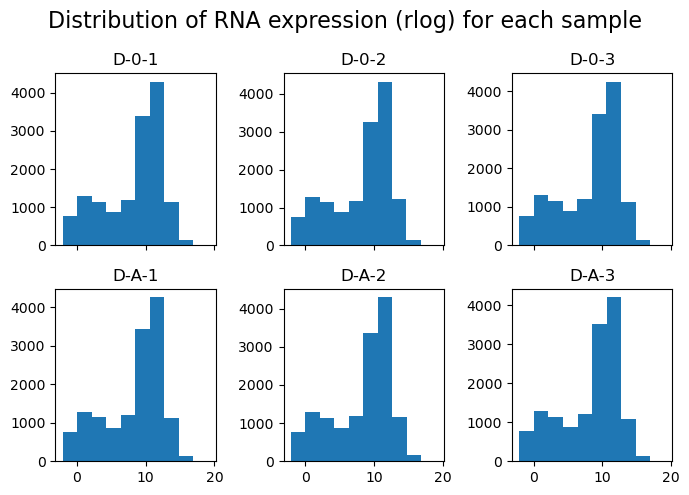

In [67]:
unique_samples = df_all["sample"].unique()
n_samples = len(unique_samples)

# Create a grid of subplots
nrows = 2
ncols = 3
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(7, 5), sharex=True)

# Iterate over unique samples
for i, v in enumerate(unique_samples):
    pltData = df_all[df_all["sample"] == v]
    counts, bins = np.histogram(pltData["rlog_transformed"])

    # Determine the correct subplot
    ax = axs[i // ncols, i % ncols]

    # Plot histogram
    ax.hist(bins[:-1], bins, weights=counts)
    ax.set_title(v)

# Adjust layout and show plot
fig.suptitle('Distribution of RNA expression (rlog) for each sample', fontsize=16)
plt.tight_layout()
plt.savefig("/Users/ahunos/myWork/coursework/FoundationsOfDataScience_F23/finals/DistributionResponses.pdf")


In [69]:
#prepare data for training
from sklearn.model_selection import train_test_split

# # Assuming x_data and y_data are already defined as per your code
x_train, x_test, y_train, y_test = train_test_split(df_sample[["geom_mean_promoter_methyl"]].values, df_sample[[ "rlog_transformed"]].values, test_size=0.2, random_state=42)
# Convert the numpy arrays to PyTorch tensors
x_data = torch.tensor(x_train, dtype=torch.float).reshape(-1, 1)
x_test_torch = torch.tensor(x_test, dtype=torch.float).reshape(-1, 1)
y_data = torch.tensor(y_train, dtype=torch.float)[:, -1]
y_test_torch = torch.tensor(y_test, dtype=torch.float)[:, -1]

# x_train = torch.tensor(x_train, dtype=torch.float).reshape(-1, 1)
# y_train = torch.tensor(y_train, dtype=torch.float)[:, -1]
# print(f'x_train.shape {x_train.shape}; y_train.shape {y_train.shape}')

# data = torch.tensor(df_sample[["geom_mean_promoter_methyl", "rlog_transformed"]].values,
#                         dtype=torch.float)
# x_data, y_data = data[:, :-1], data[:, -1]
# #x_data[:5], y_data[:5]
# print(f'x_data.shape {x_data.shape}; y_data.shape {y_data.shape}')

In [70]:
from pyro.nn import PyroSample

class BayesianRegression(PyroModule):
    def __init__(self, in_features, out_features):
        super().__init__()
        self.linear = PyroModule[nn.Linear](in_features, out_features)
        self.linear.weight = PyroSample(dist.Uniform(1., 20.).expand([out_features, in_features]).to_event(1))
        self.linear.bias = PyroSample(dist.Normal(1., 10.).expand([out_features]).to_event(1))

    def forward(self, x, y=None):
        sigma = pyro.sample("sigma", dist.Uniform(1., 10.))
        mean = self.linear(x).squeeze(-1)
        with pyro.plate("data", x.shape[0]):
            obs = pyro.sample("obs", dist.Normal(mean, sigma), obs=y)
        return mean

In [71]:
from pyro.infer.autoguide import AutoDiagonalNormal

model = BayesianRegression(1, 1)
guide = AutoDiagonalNormal(model)
model

BayesianRegression(
  (linear): PyroLinear(in_features=1, out_features=1, bias=True)
)

In [9]:
y_data

tensor([[-0.1293],
        [11.4396],
        [ 4.9827],
        ...,
        [ 2.3228],
        [11.5816],
        [ 7.3981]])

In [72]:
from pyro.infer import SVI, Trace_ELBO

adam = pyro.optim.Adam({"lr": 0.03})
svi = SVI(model, guide, adam, loss=Trace_ELBO())
num_iterations = 10000 if not smoke_test else 2
pyro.clear_param_store()
for j in range(num_iterations):
    # calculate the loss and take a gradient step
    loss = svi.step(x_data, y_data)
    if j % 100 == 0:
        print("[iteration %04d] loss: %.4f" % (j + 1, loss / len(data)))

[iteration 0001] loss: 2.7371
[iteration 0101] loss: 2.2430
[iteration 0201] loss: 2.2220
[iteration 0301] loss: 2.2103
[iteration 0401] loss: 2.2042
[iteration 0501] loss: 2.2025
[iteration 0601] loss: 2.2002
[iteration 0701] loss: 2.2000
[iteration 0801] loss: 2.1999
[iteration 0901] loss: 2.2000
[iteration 1001] loss: 2.2004
[iteration 1101] loss: 2.1999
[iteration 1201] loss: 2.2004
[iteration 1301] loss: 2.1999
[iteration 1401] loss: 2.1999
[iteration 1501] loss: 2.2005
[iteration 1601] loss: 2.2002
[iteration 1701] loss: 2.2006
[iteration 1801] loss: 2.2000
[iteration 1901] loss: 2.1999
[iteration 2001] loss: 2.2000
[iteration 2101] loss: 2.2000
[iteration 2201] loss: 2.2000
[iteration 2301] loss: 2.2001
[iteration 2401] loss: 2.2000
[iteration 2501] loss: 2.2002
[iteration 2601] loss: 2.2001
[iteration 2701] loss: 2.1999
[iteration 2801] loss: 2.2000
[iteration 2901] loss: 2.2001
[iteration 3001] loss: 2.2000
[iteration 3101] loss: 2.1998
[iteration 3201] loss: 2.2000
[iteration

In [73]:
guide.requires_grad_(False)

for name, value in pyro.get_param_store().items():
    print(name, pyro.param(name))

AutoDiagonalNormal.loc Parameter containing:
tensor([-0.8036, -0.3629,  3.3164])
AutoDiagonalNormal.scale tensor([0.0127, 0.0125, 0.0393])


In [74]:
guide.quantiles([0.25, 0.5, 0.75])

{'sigma': tensor([3.7669, 3.7834, 3.7999]),
 'linear.weight': tensor([[[8.7560]],
 
         [[8.7949]],
 
         [[8.8338]]]),
 'linear.bias': tensor([[3.2899],
         [3.3164],
         [3.3429]])}

## Model evaluation

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

In [ ]:
# tx = torch.rand(3,2,3)
# b = tx[1, :, :]
# print(tx)
# print(b)
# # print(tx[:, 1])
# print(tx[:, 1].unsqueeze(1))
# print(tx[:, 1])


In [27]:
x_test_torch.shape

torch.Size([2840, 1])

In [75]:
from pyro.infer import Predictive

def summary(samples):
    site_stats = {}
    for k, v in samples.items():
        site_stats[k] = {
            "mean": torch.mean(v, 0),
            "std": torch.std(v, 0),
            "5%": v.kthvalue(int(len(v) * 0.05), dim=0)[0],
            "95%": v.kthvalue(int(len(v) * 0.95), dim=0)[0],
        }
    return site_stats


predictive = Predictive(model, guide=guide, num_samples=800,
                        return_sites=("linear.weight", "obs", "_RETURN"))
samples = predictive(x_test_torch)
pred_summary = summary(samples)
pred_summary

{'linear.weight': {'mean': tensor([[8.7945]]),
  'std': tensor([[0.0581]]),
  '5%': tensor([[8.6995]]),
  '95%': tensor([[8.8893]])},
 'obs': {'mean': tensor([10.8414,  8.5344,  9.4492,  ..., 10.6301,  4.3007,  8.5911]),
  'std': tensor([3.6800, 3.8209, 3.7853,  ..., 3.7867, 3.8147, 3.6612]),
  '5%': tensor([ 4.6888,  2.3157,  3.1090,  ...,  4.3222, -2.0175,  2.7423]),
  '95%': tensor([16.7512, 14.5500, 15.5013,  ..., 16.7968, 10.4415, 14.7245])},
 '_RETURN': {'mean': tensor([10.6941,  8.6652,  9.6156,  ..., 10.4624,  4.1787,  8.4708]),
  'std': tensor([0.0635, 0.0539, 0.0582,  ..., 0.0624, 0.0409, 0.0531]),
  '5%': tensor([10.5893,  8.5755,  9.5186,  ..., 10.3596,  4.1121,  8.3822]),
  '95%': tensor([10.7947,  8.7497,  9.7083,  ..., 10.5614,  4.2467,  8.5543])}}

In [76]:
len(samples.items())
samples.keys()

dict_keys(['linear.weight', 'obs', '_RETURN'])

In [54]:
mu = pred_summary["_RETURN"]
y = pred_summary["obs"]

y

{'mean': tensor([10.8071,  8.6052,  9.6570,  ..., 10.8073,  3.9117,  8.7481]),
 'std': tensor([3.7177, 3.8064, 3.8041,  ..., 3.8323, 3.9827, 4.0663]),
 '5%': tensor([ 4.6587,  2.4689,  3.3087,  ...,  4.4726, -2.8016,  1.9450]),
 '95%': tensor([16.6962, 15.0382, 15.7164,  ..., 17.1463, 10.5050, 15.2625])}

In [77]:
mu = pred_summary["_RETURN"]
y = pred_summary["obs"]
predictions = pd.DataFrame({
    "Methyl": x_test_torch[:, 0],
    "mu_mean": mu["mean"],
    "mu_perc_5": mu["5%"],
    "mu_perc_95": mu["95%"],
    "y_mean": y["mean"],
    "y_perc_5": y["5%"],
    "y_perc_95": y["95%"],
    "true_RNA": y_test_torch,
})
predictions

,Methyl,mu_mean,mu_perc_5,mu_perc_95,y_mean,y_perc_5,y_perc_95,true_RNA
0,0.838963,10.694093,10.589275,10.794729,10.841360,4.688801,16.751196,12.244781
1,0.608258,8.665164,8.575469,8.749704,8.534380,2.315666,14.549991,10.771175
2,0.716327,9.615579,9.518596,9.708344,9.449183,3.108971,15.501300,10.284435
3,0.559357,8.235110,8.148604,8.316742,8.156257,1.524505,14.498391,8.046200
4,0.157671,4.702487,4.634430,4.771156,4.718318,-1.285439,10.754723,14.520488
...,...,...,...,...,...,...,...,...
2835,0.085001,4.063392,3.996690,4.131771,4.020124,-2.130746,10.166311,-0.123640
2836,0.269994,5.690307,5.619008,5.759148,5.621661,-0.531104,11.520220,5.222140
2837,0.812621,10.462428,10.359583,10.561360,10.630119,4.322223,16.796844,10.933980
2838,0.098110,4.178679,4.112146,4.246701,4.300657,-2.017463,10.441469,2.170190


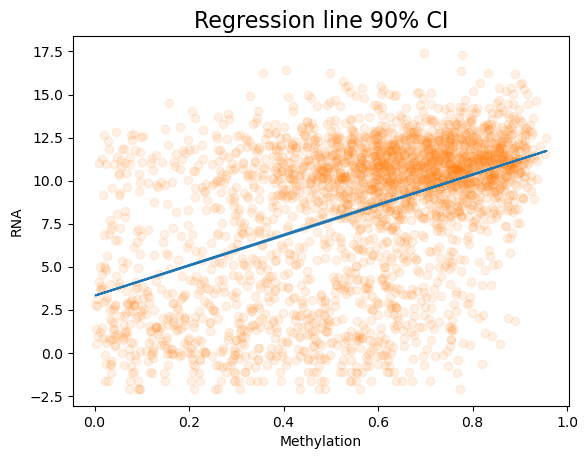

In [79]:
import matplotlib.pyplot as plt
# fig.suptitle("Regression line 90% CI", fontsize=16)
plt.plot(predictions["Methyl"],
           predictions["mu_mean"])

plt.fill_between(predictions["Methyl"],
                   predictions["mu_perc_5"],
                   predictions["mu_perc_95"],
                   alpha=0.5)

plt.scatter(predictions["Methyl"],
           predictions["true_RNA"], alpha=0.1)
plt.xlabel("Methylation")
plt.ylabel("RNA")
plt.title("Regression line 90% CI", fontsize=16)
# plt.show()
plt.savefig("/Users/ahunos/myWork/coursework/FoundationsOfDataScience_F23/finals/RegressionLine90CI.pdf")

#idx = np.argsort(predictions["Methyl"])

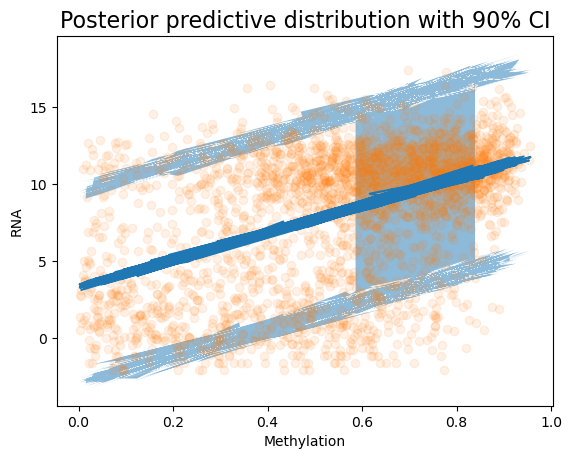

In [80]:
# fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6), sharey=True)
# fig.suptitle("Posterior predictive distribution with 90% CI", fontsize=16)
plt.plot(predictions["Methyl"],
           predictions["y_mean"])

plt.fill_between(predictions["Methyl"],
                   predictions["y_perc_5"],
                   predictions["y_perc_95"],
                   alpha=0.5)
plt.scatter(predictions["Methyl"],
           predictions["true_RNA"],alpha=0.1)
plt.xlabel("Methylation")
plt.ylabel("RNA")
plt.title("Posterior predictive distribution with 90% CI", fontsize=16)
plt.savefig("/Users/ahunos/myWork/coursework/FoundationsOfDataScience_F23/finals/PosteriorPredictiveDist90CI.pdf")


torch.Size([800, 1, 1])


/Users/ahunos/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


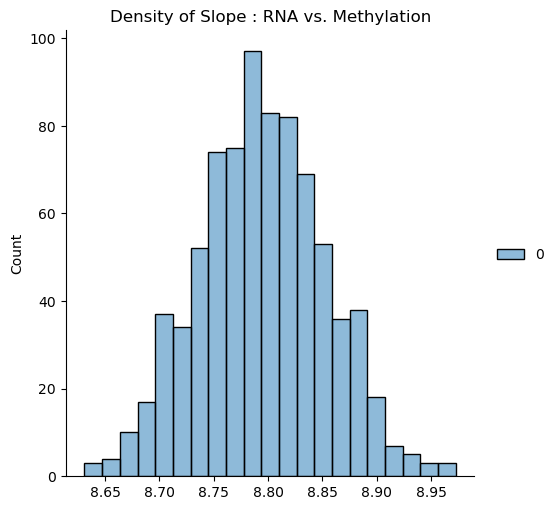

In [81]:
weight = samples["linear.weight"]
print(weight.shape)
weight = weight.reshape(weight.shape[0],1)
weight.shape

sns.displot(weight, kde_kws={"label": "d-0-1"})
plt.title("Density of Slope : RNA vs. Methylation")
plt.savefig("/Users/ahunos/myWork/coursework/FoundationsOfDataScience_F23/finals/DensitySlopes.pdf")
